## Importing Libraries

In [596]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error, r2_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


from xgboost import XGBRegressor


## Understanding the data

In [597]:
directory_path_1 = '/home/pc/Desktop_linux/chinu/food_demand_forecasting/train_GzS76OK'
directory_path_2 = '/home/pc/Desktop_linux/chinu/food_demand_forecasting'

file_name_1 = 'meal_info.csv'
file_name_2 = 'fulfilment_center_info.csv'
file_name_3 = 'train.csv'
test_file_name = 'test_QoiMO9B.csv'

file_1 = os.path.join(directory_path_1, file_name_1)
file_2 = os.path.join(directory_path_1, file_name_2)
file_3 = os.path.join(directory_path_1, file_name_3)
test_file = os.path.join(directory_path_2, test_file_name)

meal = pd.read_csv(file_1)
center = pd.read_csv(file_2)
train_df = pd.read_csv(file_3)
unseen_df = pd.read_csv(test_file)

print(meal.head())
print(center.head())
print(train_df)
print(unseen_df)

   meal_id   category cuisine
0     1885  Beverages    Thai
1     1993  Beverages    Thai
2     2539  Beverages    Thai
3     1248  Beverages  Indian
4     2631  Beverages  Indian
   center_id  city_code  region_code center_type  op_area
0         11        679           56      TYPE_A      3.7
1         13        590           56      TYPE_B      6.7
2        124        590           56      TYPE_C      4.0
3         66        648           34      TYPE_A      4.1
4         94        632           34      TYPE_C      3.6
             id  week  center_id  meal_id  checkout_price  base_price  \
0       1379560     1         55     1885          136.83      152.29   
1       1466964     1         55     1993          136.83      135.83   
2       1346989     1         55     2539          134.86      135.86   
3       1338232     1         55     2139          339.50      437.53   
4       1448490     1         55     2631          243.50      242.50   
...         ...   ...        ...  

In [598]:
center['region_code'] = center['region_code'].astype('category')

In [599]:
train_df.shape, center.shape, meal.shape, unseen_df.shape

((456548, 9), (77, 5), (51, 3), (32573, 8))

In [600]:
train_df.center_id.nunique(), train_df.meal_id.nunique()

(77, 51)

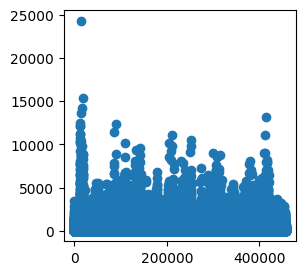

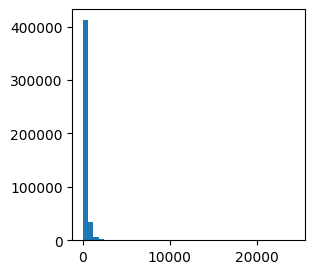

In [601]:
plt.figure(figsize=(3,3))
plt.scatter(x=train_df.index, y=train_df['num_orders'])
plt.show()

plt.figure(figsize=(3,3))
plt.hist(train_df['num_orders'], bins=40)
plt.show()

In [602]:
# There is no missing values

print(train_df.isna().sum())
print(meal.isna().sum())
print(center.isna().sum())
print(unseen_df.isna().sum())

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64
meal_id     0
category    0
cuisine     0
dtype: int64
center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64
id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64


## Merging the tables

In [603]:
train_df = pd.merge(train_df, center, how='left', on='center_id')
train_df = pd.merge(train_df, meal, how='left', on='meal_id')

unseen_df = pd.merge(unseen_df, center, how='left', on='center_id')
unseen_df = pd.merge(unseen_df, meal, how='left', on='meal_id')

train_df.head(), unseen_df.head()

(        id  week  center_id  meal_id  checkout_price  base_price  \
 0  1379560     1         55     1885          136.83      152.29   
 1  1466964     1         55     1993          136.83      135.83   
 2  1346989     1         55     2539          134.86      135.86   
 3  1338232     1         55     2139          339.50      437.53   
 4  1448490     1         55     2631          243.50      242.50   
 
    emailer_for_promotion  homepage_featured  num_orders  city_code  \
 0                      0                  0         177        647   
 1                      0                  0         270        647   
 2                      0                  0         189        647   
 3                      0                  0          54        647   
 4                      0                  0          40        647   
 
   region_code center_type  op_area   category cuisine  
 0          56      TYPE_C      2.0  Beverages    Thai  
 1          56      TYPE_C      2.0  Bever

In [604]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   id                     456548 non-null  int64   
 1   week                   456548 non-null  int64   
 2   center_id              456548 non-null  int64   
 3   meal_id                456548 non-null  int64   
 4   checkout_price         456548 non-null  float64 
 5   base_price             456548 non-null  float64 
 6   emailer_for_promotion  456548 non-null  int64   
 7   homepage_featured      456548 non-null  int64   
 8   num_orders             456548 non-null  int64   
 9   city_code              456548 non-null  int64   
 10  region_code            456548 non-null  category
 11  center_type            456548 non-null  object  
 12  op_area                456548 non-null  float64 
 13  category               456548 non-null  object  
 14  cuisine             

In [605]:
unseen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     32573 non-null  int64   
 1   week                   32573 non-null  int64   
 2   center_id              32573 non-null  int64   
 3   meal_id                32573 non-null  int64   
 4   checkout_price         32573 non-null  float64 
 5   base_price             32573 non-null  float64 
 6   emailer_for_promotion  32573 non-null  int64   
 7   homepage_featured      32573 non-null  int64   
 8   city_code              32573 non-null  int64   
 9   region_code            32573 non-null  category
 10  center_type            32573 non-null  object  
 11  op_area                32573 non-null  float64 
 12  category               32573 non-null  object  
 13  cuisine                32573 non-null  object  
dtypes: category(1), float64(3), int64(7), 

## Dividing the feature into categorical or numerical

In [606]:
# for feature in train_df.columns:
#     print(feature)
#     plt.figure(figsize=(4,4))
#     plt.scatter(train_df['id'], y=train_df[feature])
#     plt.show()

## Visualising the data

<Axes: xlabel='cuisine', ylabel='num_orders'>

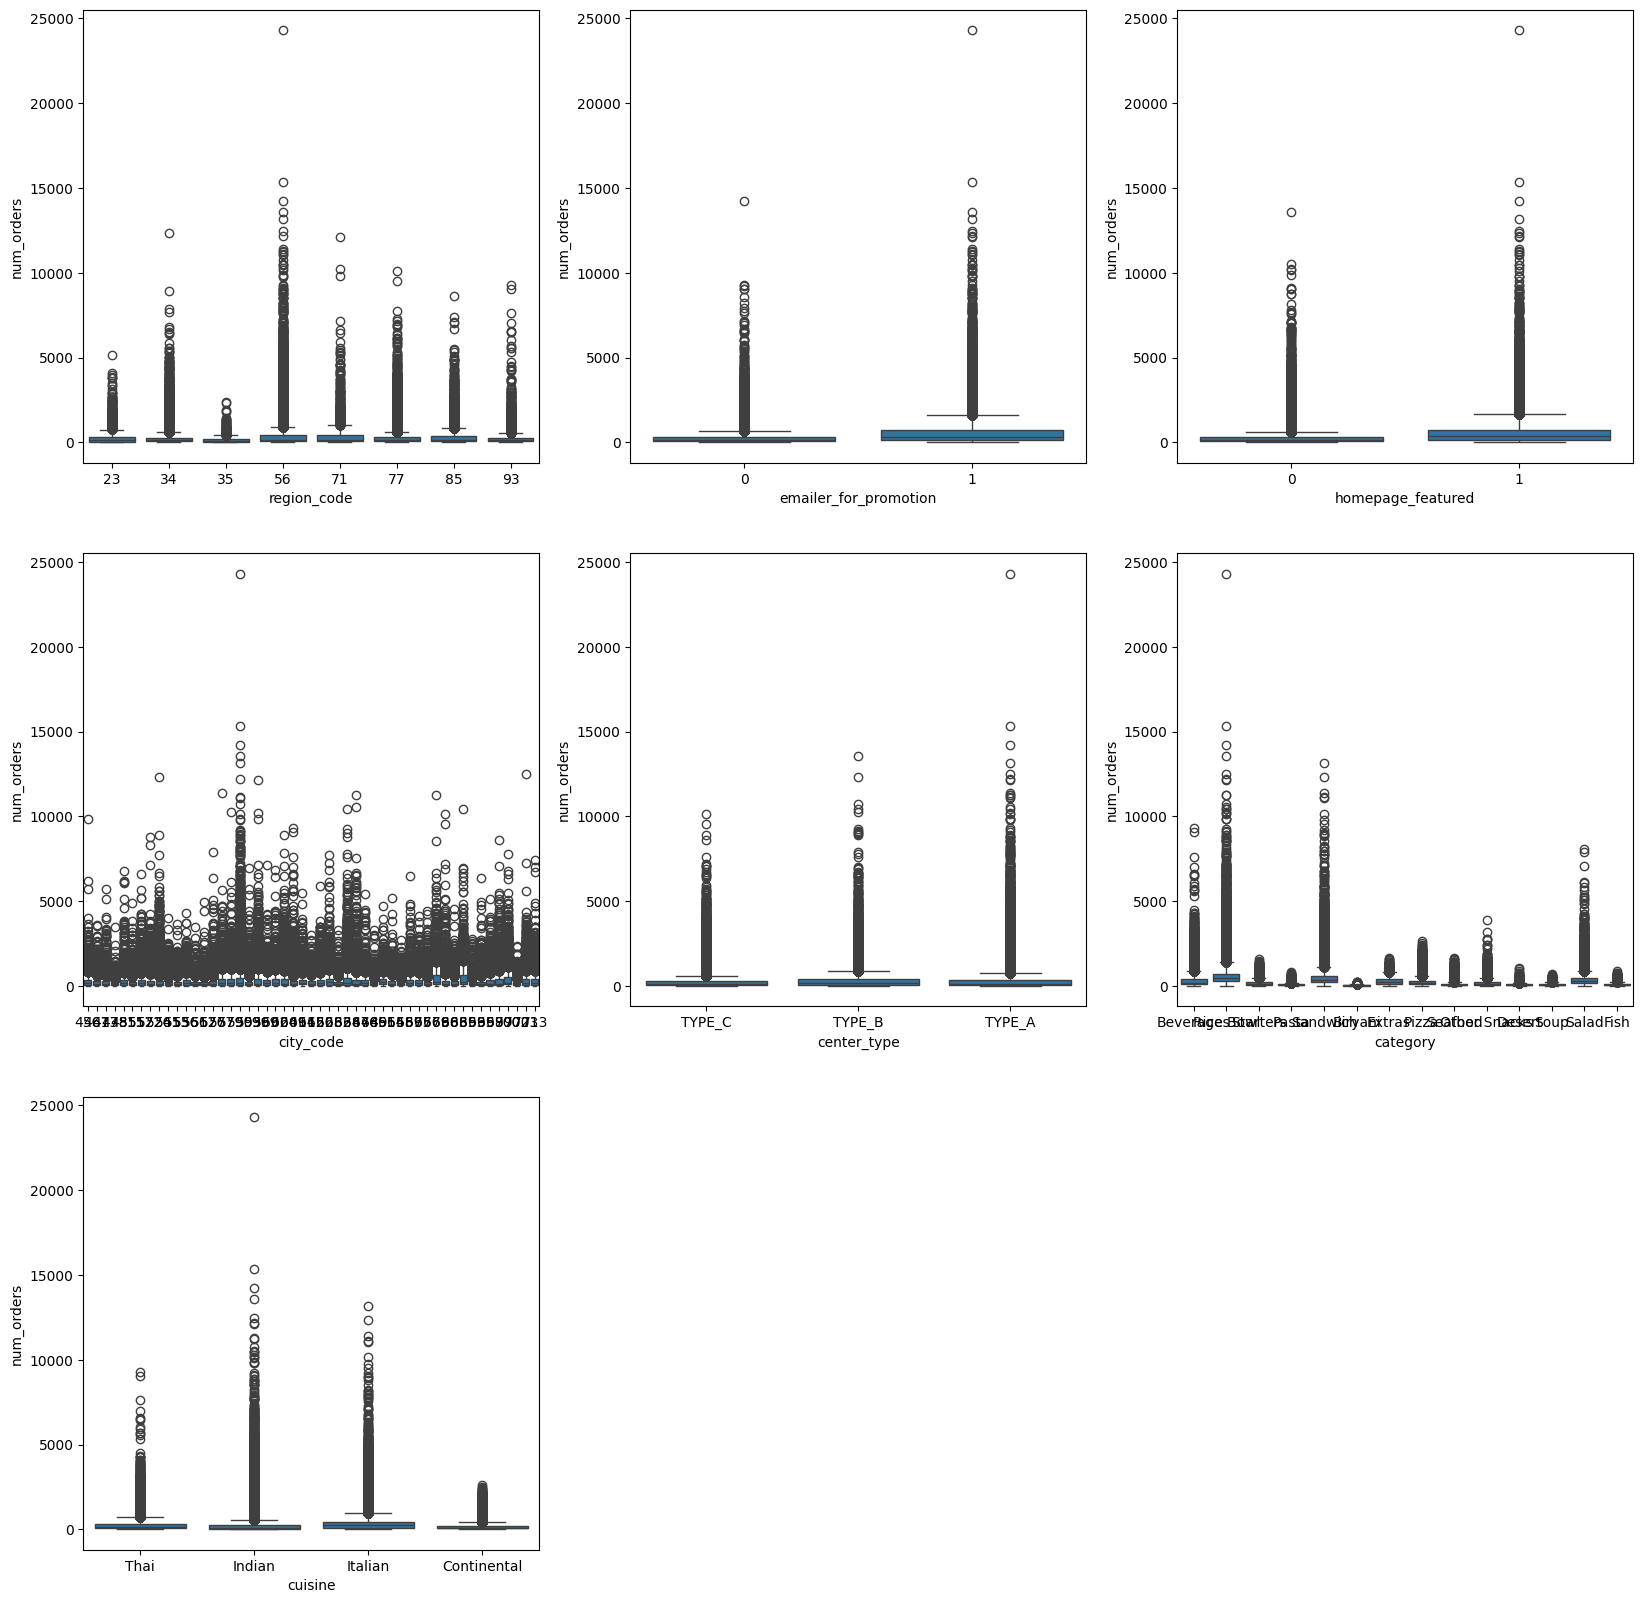

In [607]:
plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
sns.boxplot(data=train_df, x='region_code', y='num_orders')

plt.subplot(3,3,2)
sns.boxplot(data=train_df, x='emailer_for_promotion', y='num_orders')

plt.subplot(3,3,3)
sns.boxplot(data=train_df, x='homepage_featured', y='num_orders')

plt.subplot(3,3,4)
sns.boxplot(data=train_df, x='city_code', y='num_orders')

plt.subplot(3,3,5)
sns.boxplot(data=train_df, x='center_type', y='num_orders')

plt.subplot(3,3,6)
sns.boxplot(data=train_df, x='category', y='num_orders')

plt.subplot(3,3,7)
sns.boxplot(data=train_df, x='cuisine', y='num_orders')


### Insight:  
- there is no missing values.  

In [608]:
numeric = [ 'checkout_price', 'base_price',  'op_area','num_orders']
categorical = ['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code', 'center_type',  'category', 'cuisine']

## Correlation

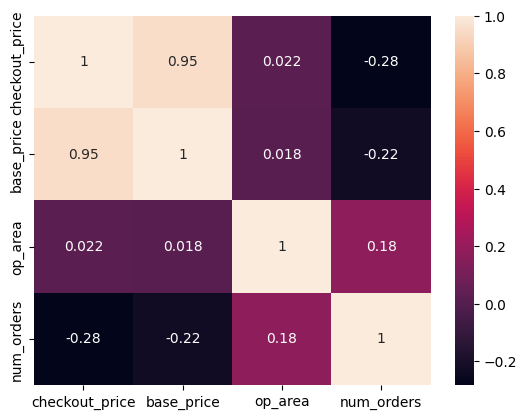

In [609]:
sns.heatmap(train_df[numeric].corr(), annot=True)
plt.show()

## Insight:  
- There is a high correlation between 'checkout_price' and 'base_price'. 
- I should take only one variable in regression.

## Plots of numeric variable

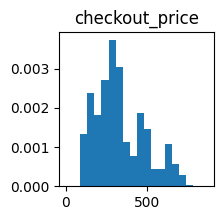

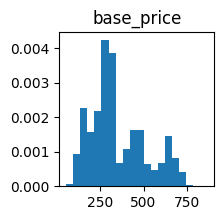

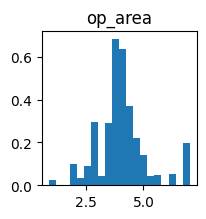

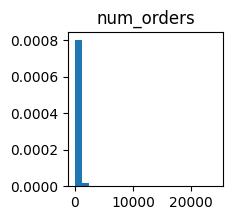

In [610]:
for feature in numeric:
    plt.figure(figsize=(2,2))
    plt.hist(train_df[feature], bins=20, density=True)
    # sns.histplot(train_df_2[feature])
    plt.title(feature)
    plt.show()

## Insight:
- choosing 'checkout_price' feature over 'base_price' as it is comparitivly more normally distributed.  


## One hot encoding for categorical

In [611]:
one_hot_columns = ['emailer_for_promotion', 'homepage_featured', 'region_code', 'center_type', 'category', 'cuisine']
dummy_df = pd.get_dummies(train_df[one_hot_columns])
train_df = pd.concat([train_df, dummy_df], axis=1)

dummy_df = pd.get_dummies(unseen_df[one_hot_columns])
unseen_df = pd.concat([unseen_df, dummy_df], axis=1)


## Checking unseen_df and train_df have same columns

In [612]:
for feature_train in train_df.columns:
    if feature_train not in unseen_df.columns:
        print(feature_train)


for feature in unseen_df.columns:
    if feature not in train_df.columns:
        print(feature)

num_orders



## Assign scores to center_id

In [613]:
center_df = train_df.groupby(by='center_id')['num_orders'].sum().reset_index()
scaler = MinMaxScaler()
center_df['center_score'] = scaler.fit_transform(center_df[['num_orders']])
center_df['center_score'] = center_df['center_score'].apply(lambda x: round(x, 3))

train_df = train_df.merge(center_df[['center_id', 'center_score']], how='left', on='center_id')
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai,center_score
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,...,False,False,False,False,False,False,False,False,True,0.107
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,...,False,False,False,False,False,False,False,False,True,0.107
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,...,False,False,False,False,False,False,False,False,True,0.107
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,...,False,False,False,False,False,False,True,False,False,0.107
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,...,False,False,False,False,False,False,True,False,False,0.107


In [614]:
unseen_df = unseen_df.merge(center_df[['center_id', 'center_score']], how='left', on='center_id')
unseen_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,...,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai,center_score
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,...,False,False,False,False,False,False,False,False,True,0.107
1,1127204,146,55,1993,160.11,159.11,0,0,647,56,...,False,False,False,False,False,False,False,False,True,0.107
2,1212707,146,55,2539,157.14,159.14,0,0,647,56,...,False,False,False,False,False,False,False,False,True,0.107
3,1082698,146,55,2631,162.02,162.02,0,0,647,56,...,False,False,False,False,False,False,True,False,False,0.107
4,1400926,146,55,1248,163.93,163.93,0,0,647,56,...,False,False,False,False,False,False,True,False,False,0.107


## Assign scores to meal_id

In [615]:
meal_df = train_df.groupby(by='meal_id')[['num_orders']].sum().reset_index()
scaler = MinMaxScaler()
meal_df['meal_score'] = scaler.fit_transform(meal_df[['num_orders']])
meal_df['meal_score'] = meal_df['meal_score'].apply(lambda x: round(x, 3))
train_df = train_df.merge(meal_df[['meal_id', 'meal_score']], how='left', on='meal_id')
train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai,center_score,meal_score
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,...,False,False,False,False,False,False,False,True,0.107,0.852
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,...,False,False,False,False,False,False,False,True,0.107,0.676
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,...,False,False,False,False,False,False,False,True,0.107,0.320
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,...,False,False,False,False,False,True,False,False,0.107,0.023
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,...,False,False,False,False,False,True,False,False,0.107,0.097


In [616]:
unseen_df = unseen_df.merge(meal_df[['meal_id', 'meal_score']], how='left', on='meal_id')
unseen_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,...,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai,center_score,meal_score
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,...,False,False,False,False,False,False,False,True,0.107,0.852
1,1127204,146,55,1993,160.11,159.11,0,0,647,56,...,False,False,False,False,False,False,False,True,0.107,0.676
2,1212707,146,55,2539,157.14,159.14,0,0,647,56,...,False,False,False,False,False,False,False,True,0.107,0.320
3,1082698,146,55,2631,162.02,162.02,0,0,647,56,...,False,False,False,False,False,True,False,False,0.107,0.097
4,1400926,146,55,1248,163.93,163.93,0,0,647,56,...,False,False,False,False,False,True,False,False,0.107,0.074


## Drop columns

In [617]:
drop_columns = ['id', 'week', 'center_id', 'meal_id', 'city_code',
                'base_price', 'emailer_for_promotion', 'homepage_featured',
                'region_code', 'center_type', 'category', 'cuisine']
train_df = train_df.drop(columns=drop_columns)
unseen_df = unseen_df.drop(columns=drop_columns)


## Train - Test split

In [618]:
y = train_df[['num_orders']]
X = train_df.drop(columns='num_orders')
y.shape, X.shape

((456548, 1), (456548, 33))

In [619]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((319583, 33), (136965, 33), (319583, 1), (136965, 1))

In [620]:
unseen_df.shape

(32573, 33)

## Model Evaluation

In [621]:
def model_evaluation(y_train, y_test, y_train_pred, y_test_pred, y_train_pred_clip, y_test_pred_clip, model='model'):
    print('* ' * 15, f'{model}', ' *' * 15)
    print(" For Train Data : ")
    msle_train = mean_squared_log_error(y_train, y_train_pred_clip)
    print('RMSLE = ', msle_train)

    r2_score_train = r2_score(y_train, y_train_pred)
    print("R2 Score  = ", r2_score_train)

    print(" ")
    print("\n For Test Data : ")
    msle_test = mean_squared_log_error(y_test, y_test_pred_clip)
    print('RMSLE = ', msle_test)

    r2_score_test = r2_score(y_test, y_test_pred)
    print("R2 Score  = ", r2_score_test)

## Linear Regression

In [622]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [623]:
y_train_pred = reg.predict(X_train).astype(int)
y_test_pred = reg.predict(X_test).astype(int)

y_train_pred_clip = np.clip(y_train_pred, 0, None)
y_test_pred_clip = np.clip(y_test_pred, 0, None)
model_evaluation(y_train, y_test, y_train_pred, y_test_pred, y_train_pred_clip, y_test_pred_clip, reg)

* * * * * * * * * * * * * * *  LinearRegression()  * * * * * * * * * * * * * * *
 For Train Data : 
RMSLE =  2.401602735359102
R2 Score  =  0.4016232326777778
 

 For Test Data : 
RMSLE =  2.425651078429367
R2 Score  =  0.4005428607078766


## Random Forest

In [624]:
param = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, 20],
    # 'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

msle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)

model = RandomForestRegressor()
grid = GridSearchCV(estimator=model,
                    param_grid=param,
                    cv=4,
                    scoring=msle_scorer,
                    verbose=2,
                    n_jobs=-1)

grid.fit(X_train, y_train.squeeze())
print(grid.best_estimator_)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=100; total time= 2.0min
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time= 2.5min
[CV] END ..max_depth=15, min_samples_leaf=1, n_estimators=50; total time= 1.2min
[CV] END .max_depth=15, min_samples_leaf=2, n_estimators=100; total time= 2.3min
[CV] END ..max_depth=20, min_samples_leaf=1, n_estimators=50; total time= 1.4min


/home/pc/Desktop_linux/chinu/common_kernel/virtual_env/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=150; total time= 2.1min
[CV] END ..max_depth=10, min_samples_leaf=2, n_estimators=50; total time= 1.0min
[CV] END ..max_depth=10, min_samples_leaf=4, n_estimators=50; total time= 1.1min
[CV] END .max_depth=10, min_samples_leaf=4, n_estimators=150; total time= 3.0min
[CV] END ..max_depth=15, min_samples_leaf=4, n_estimators=50; total time= 1.2min
[CV] END .max_depth=20, min_samples_leaf=1, n_estimators=100; total time= 2.6min
[CV] END ...max_depth=5, min_samples_leaf=1, n_estimators=50; total time= 1.0min
[CV] END ..max_depth=5, min_samples_leaf=4, n_estimators=100; total time= 1.9min
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=150; total time= 3.4min
[CV] END .max_depth=15, min_samples_leaf=2, n_estimators=150; total time= 3.5min
[CV] END .max_depth=20, min_samples_leaf=2, n_estimators=100; total time= 2.5min
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=150; total time= 2.0min
[CV] END .max_depth=10, min_

In [626]:
print(grid.best_estimator_, grid.best_score_)


RandomForestRegressor(max_depth=20, min_samples_leaf=4, n_estimators=150) -0.27876833710427545


In [627]:
random1 = RandomForestRegressor(max_depth=20, min_samples_leaf=4, n_estimators=150, random_state=42)
random1.fit(X_train, y_train.squeeze())

RandomForestRegressor(max_depth=20, min_samples_leaf=4, n_estimators=150,
                      random_state=42)

In [628]:
y_train_pred = random1.predict(X_train).astype(int)
y_test_pred = random1.predict(X_test).astype(int)
unseen_pred = random1.predict(unseen_df).astype(int)

y_train_pred_clip = np.clip(y_train_pred, 0, None)
y_test_pred_clip = np.clip(y_test_pred, 0, None)
unseen_pred_clip = np.clip(unseen_pred, 0, None)
model_evaluation(y_train, y_test, y_train_pred, y_test_pred, y_train_pred_clip, y_test_pred_clip, random1)

* * * * * * * * * * * * * * *  RandomForestRegressor(max_depth=20, min_samples_leaf=4, n_estimators=150,
                      random_state=42)  * * * * * * * * * * * * * * *
 For Train Data : 
RMSLE =  0.22052678432642525
R2 Score  =  0.8443426331109453
 

 For Test Data : 
RMSLE =  0.2740324877589686
R2 Score  =  0.7642266582181124


## XG Boosting

In [ ]:
xgb = XGBRegressor()
param ={
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    # 'gamma': [0, 1, 5],
    # 'reg_alpha': [0, 0.1, 1],
    # 'reg_lambda': [1, 2, 5]
}

scoring = make_scorer(mean_squared_log_error)
# scoring = make_scorer(mean_squared_log_error, greater_is_better=False)

rand_search = RandomizedSearchCV(
                                    estimator=xgb,
                                    param_distributions=param,
                                    scoring=scoring,
                                    cv=3,          # 3-fold cross-validation
                                    verbose=2,     # Show progress
                                    n_jobs=-1      # Use all available CPU cores
                                )

rand_search.fit(X_train, y_train)

## Submission file

In [629]:
unseen_df = pd.read_csv(test_file)
submission_df = unseen_df[['id']]
submission_df['num_orders'] = unseen_pred_clip
submission_df.head(), submission_df.shape, submission_df.columns

/tmp/ipykernel_2241779/1764873191.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['num_orders'] = unseen_pred_clip


(        id  num_orders
 0  1028232         113
 1  1127204         150
 2  1212707         210
 3  1082698          48
 4  1400926          38,
 (32573, 2),
 Index(['id', 'num_orders'], dtype='object'))

In [630]:
file_name = 'Output_random_forest_2.csv'
submission_file = os.path.join(directory_path_2, file_name)
submission_df.to_csv(submission_file, index=False)

# Model Name
# random1 = RandomForestRegressor(max_depth=20, min_samples_leaf=4, n_estimators=150, random_state=42)


In [673]:
import nbconvert

# Specify the notebook file
file_1 = "forecasting.ipynb"
notebook_filename = os.path.join(directory_path_2, file_1)

# Convert the notebook to a Python script
exporter = nbconvert.PythonExporter()
script, _ = exporter.from_filename(notebook_filename)

# Save the script to a file
file_1 = "forecasting_submission_3.py"
notebook_filename = os.path.join(directory_path_2, file_1)
with open(notebook_filename, "w") as f:
    f.write(script)
